In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lsay-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5181295%2F8650027%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240904%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240904T204134Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4be452787f771ce7500d253ca16f2ae9eeb3cbe79ebbe35288da2bd97c24042689475d5c723c75ff0bec25792580ae35ffb92219fef9ec446f2ab80930c8755e7e0ccf80a282aec233c03e5be315342594324962e919b8d2c874a22ec61b3b88fbbed9c190875065216a2fe7a80c88896ab7fcb19331d108f13287cbce89ff354dbc40c088a6edf72dd194297d66514282fad817ee0f4c1edba130d68b5520e0f20a4d16972b7e7cfb2691510172e64ba75432525e26a01f8fac6e9d5655e49d683ee7cb3c9586dac39c2f24f349c05c375031a914501b3d44342667663050acc237fbc3753e8c79f724173426a7bc04ea089a0bfe1ac7765c2ecf98c19d5f6a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 21037645 bytes downloaded
Downloaded and uncompressed: lsay-dataset
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lsay-dataset/30263-0001-Data.csv


# Import necessary libraries

In [3]:

import os
import sys
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import unquote, urlparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay


# Set visual style for plots

In [4]:

sns.set(style="whitegrid")

# Load dataset

In [5]:
df = pd.read_csv('/kaggle/input/lsay-dataset/30263-0001-Data.csv')


# Define variables related to fall and spring semesters


In [6]:
fall_vars = ['GAMTH1C', 'GAMTH1D', 'GAMTH1E', 'GAMTH1H', 'GAMTH2C', 'GASCI1D', 'GASCI1E', 'GASCI1H', 'GASCI2C', 'GASCI2D',
             'GAENG1C', 'GAENG1D', 'GAENG1E', 'GAENG2C', 'GAENG2D', 'GASSTC', 'GASSTD', 'GACOMC', 'GACOMD', 'GAFORC',
             'GAARTC', 'GAMUSC', 'GAVOCC', 'GA32A', 'GA32D', 'GA33A', 'GA33D']

spring_vars = ['HAMTH1C', 'HAMTH1D', 'HAMTH2C', 'HASCI1C', 'HASCI2C', 'HAENG1C', 'HAENG2C', 'HASSTC', 'HACOMC',
               'HAFORC', 'HAARTC', 'HAMUSC', 'HAVOCC']


In [7]:
# Filter data for fall and spring semesters
fall_data = df[fall_vars]
spring_data = df[spring_vars]


In [8]:
# Encode target variable (college major)
label_encoder = LabelEncoder()
df['LAMAJOR8I_encoded'] = label_encoder.fit_transform(df['LAMAJOR8I'])

In [9]:
# Ensure that `fall_data` and `spring_data` are properly defined DataFrames
# and not views of the original DataFrame `df`

# Correcting SettingWithCopyWarning for fall_data
fall_data = df[fall_vars + ['LAMAJOR8I']].copy()  # Create a copy of the DataFrame
fall_data.loc[:, 'LAMAJOR8I'] = df['LAMAJOR8I']  # Explicitly set the target variable in the copy

# Correcting SettingWithCopyWarning for spring_data
spring_data = df[spring_vars + ['LAMAJOR8I']].copy()  # Create a copy of the DataFrame
spring_data.loc[:, 'LAMAJOR8I'] = df['LAMAJOR8I']  # Explicitly set the target variable in the copy




In [10]:
# Split data into training and test sets for both semesters
X_fall = fall_data.drop('LAMAJOR8I', axis=1)
y_fall = fall_data['LAMAJOR8I']
X_spring = spring_data.drop('LAMAJOR8I', axis=1)
y_spring = spring_data['LAMAJOR8I']


In [11]:
X_fall_train, X_fall_test, y_fall_train, y_fall_test = train_test_split(X_fall, y_fall, test_size=0.2, random_state=42)
X_spring_train, X_spring_test, y_spring_train, y_spring_test = train_test_split(X_spring, y_spring, test_size=0.2, random_state=42)


In [12]:
# Standardize features
scaler = StandardScaler()
X_fall_train = scaler.fit_transform(X_fall_train)
X_fall_test = scaler.transform(X_fall_test)
X_spring_train = scaler.fit_transform(X_spring_train)
X_spring_test = scaler.transform(X_spring_test)

In [13]:

# Train Random Forest models for both fall and spring data
model_fall = RandomForestClassifier(random_state=42)
model_fall.fit(X_fall_train, y_fall_train)
model_spring = RandomForestClassifier(random_state=42)
model_spring.fit(X_spring_train, y_spring_train)


RandomForestClassifier(random_state=42)

In [14]:
# Make predictions
y_fall_pred = model_fall.predict(X_fall_test)
y_spring_pred = model_spring.predict(X_spring_test)

In [15]:
# Evaluate models
print("Fall Semester Model Evaluation:")
print(confusion_matrix(y_fall_test, y_fall_pred))
print(classification_report(y_fall_test, y_fall_pred))

print("Spring Semester Model Evaluation:")
print(confusion_matrix(y_spring_test, y_spring_pred))
print(classification_report(y_spring_test, y_spring_pred))


Fall Semester Model Evaluation:
[[  0   1   0   0   0   0   0   0   0   0   0   0]
 [  0 544   3   0   1   0   5   4   1  17   2   6]
 [  0  31   1   0   0   0   1   0   0   2   0   1]
 [  0   4   0   0   0   0   0   0   0   1   0   0]
 [  0  37   1   0   1   0   0   0   0   1   0   0]
 [  0   5   0   0   0   0   0   0   0   1   0   0]
 [  0  50   0   0   1   0   2   0   0   5   0   0]
 [  0  37   0   0   0   0   0   0   1   5   3   1]
 [  0  64   1   0   0   0   2   1   1   2   0   1]
 [  0 127   0   0   1   0   0   2   0  11   2   2]
 [  0  63   0   0   0   0   0   2   0   5   0   2]
 [  0 114   2   0   0   0   0   0   2   4   0   2]]
              precision    recall  f1-score   support

         -95       0.00      0.00      0.00         1
           0       0.51      0.93      0.66       583
           1       0.12      0.03      0.05        36
           2       0.00      0.00      0.00         5
           3       0.25      0.03      0.05        40
           4       0.00      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [16]:
# Feature importance for both semesters
fall_feature_importance = pd.DataFrame(model_fall.feature_importances_, index=X_fall.columns, columns=['Importance']).sort_values('Importance', ascending=False)
spring_feature_importance = pd.DataFrame(model_spring.feature_importances_, index=X_spring.columns, columns=['Importance']).sort_values('Importance', ascending=False)


<ipython-input-17-997f8fc9a448>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fall_feature_importance.Importance, y=fall_feature_importance.index, palette='viridis')


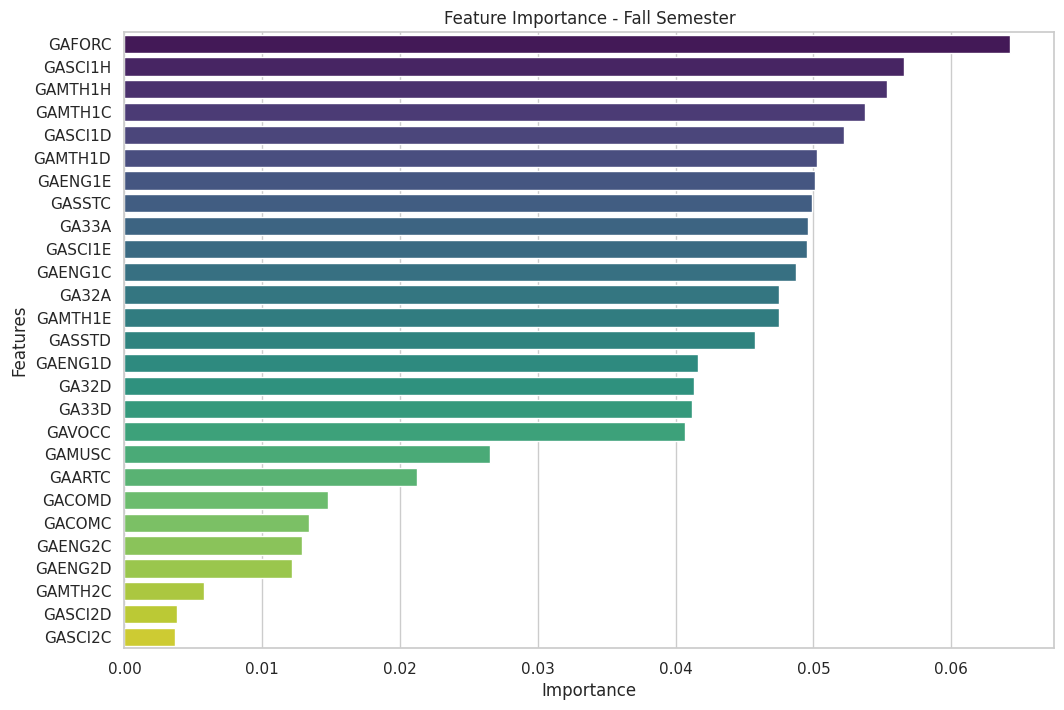

<ipython-input-17-997f8fc9a448>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=spring_feature_importance.Importance, y=spring_feature_importance.index, palette='magma')


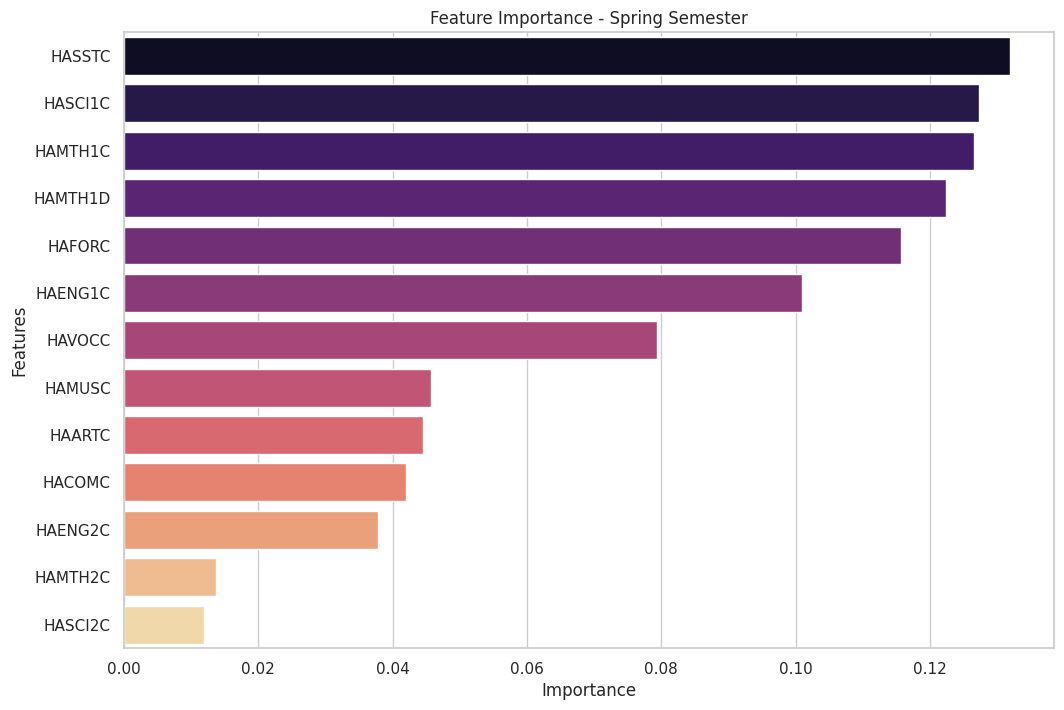

In [17]:

# Plotting feature importance for fall and spring semesters
plt.figure(figsize=(12, 8))
sns.barplot(x=fall_feature_importance.Importance, y=fall_feature_importance.index, palette='viridis')
plt.title('Feature Importance - Fall Semester')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x=spring_feature_importance.Importance, y=spring_feature_importance.index, palette='magma')
plt.title('Feature Importance - Spring Semester')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

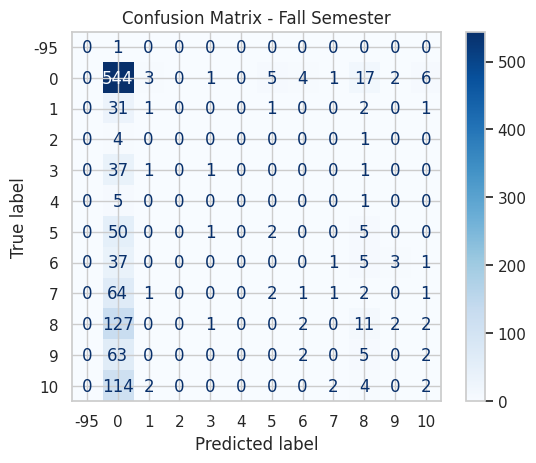

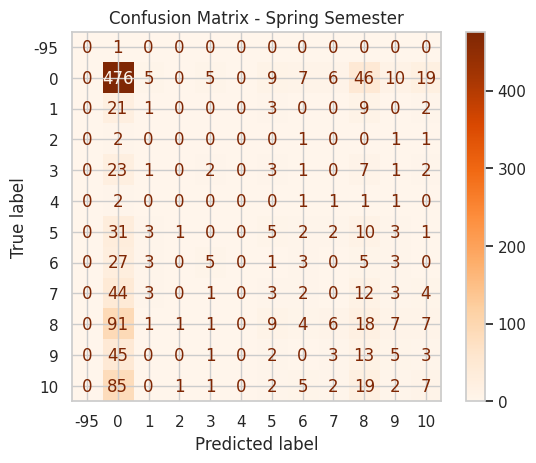

In [18]:
# Plot confusion matrix for fall and spring
cm_fall = confusion_matrix(y_fall_test, y_fall_pred)
ConfusionMatrixDisplay(cm_fall, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.title('Confusion Matrix - Fall Semester')
plt.show()

cm_spring = confusion_matrix(y_spring_test, y_spring_pred)
ConfusionMatrixDisplay(cm_spring, display_labels=label_encoder.classes_).plot(cmap='Oranges')
plt.title('Confusion Matrix - Spring Semester')
plt.show()

In [19]:
# Binarize target variable for ROC curve
y_fall_test_binarized = label_binarize(y_fall_test, classes=[0, 1, 2])  # Adjust classes based on your labels
y_spring_test_binarized = label_binarize(y_spring_test, classes=[0, 1, 2])
n_classes = y_fall_test_binarized.shape[1]

In [20]:
# One-vs-Rest (OvR) classification
ovr_fall = OneVsRestClassifier(model_fall)
ovr_fall.fit(X_fall_train, y_fall_train)

ovr_spring = OneVsRestClassifier(model_spring)
ovr_spring.fit(X_spring_train, y_spring_train)

OneVsRestClassifier(estimator=RandomForestClassifier(random_state=42))

In [21]:
# ROC curve for fall and spring
fpr_fall, tpr_fall, roc_auc_fall = dict(), dict(), dict()
fpr_spring, tpr_spring, roc_auc_spring = dict(), dict(), dict()

for i in range(n_classes):
    fpr_fall[i], tpr_fall[i], _ = roc_curve(y_fall_test_binarized[:, i], ovr_fall.predict_proba(X_fall_test)[:, i])
    roc_auc_fall[i] = auc(fpr_fall[i], tpr_fall[i])

    fpr_spring[i], tpr_spring[i], _ = roc_curve(y_spring_test_binarized[:, i], ovr_spring.predict_proba(X_spring_test)[:, i])
    roc_auc_spring[i] = auc(fpr_spring[i], tpr_spring[i])

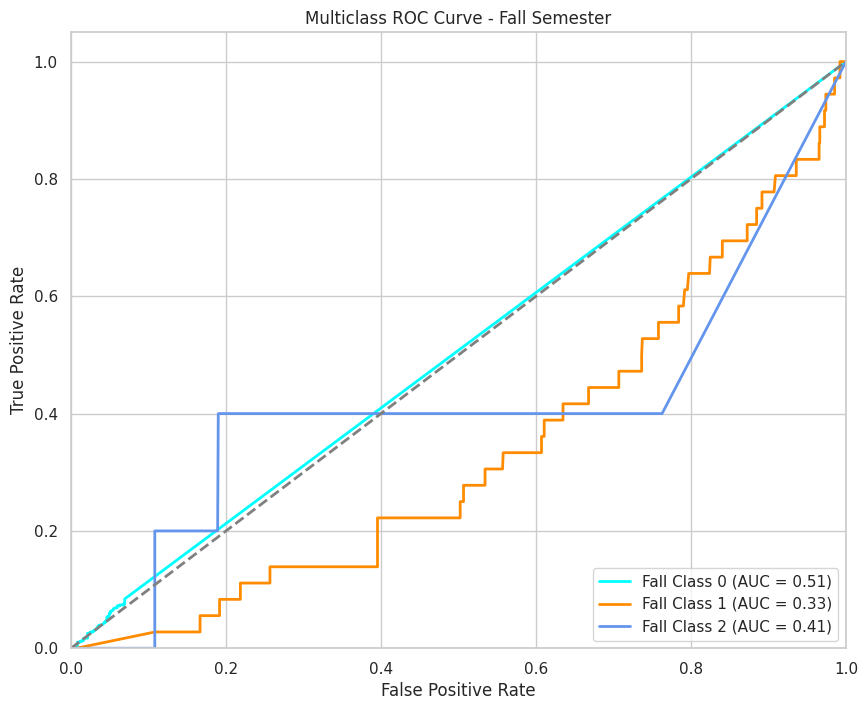

In [22]:
# Plot ROC curves for fall semester
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_fall[i], tpr_fall[i], color=color, lw=2, label=f'Fall Class {i} (AUC = {roc_auc_fall[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve - Fall Semester')
plt.legend(loc="lower right")
plt.show()

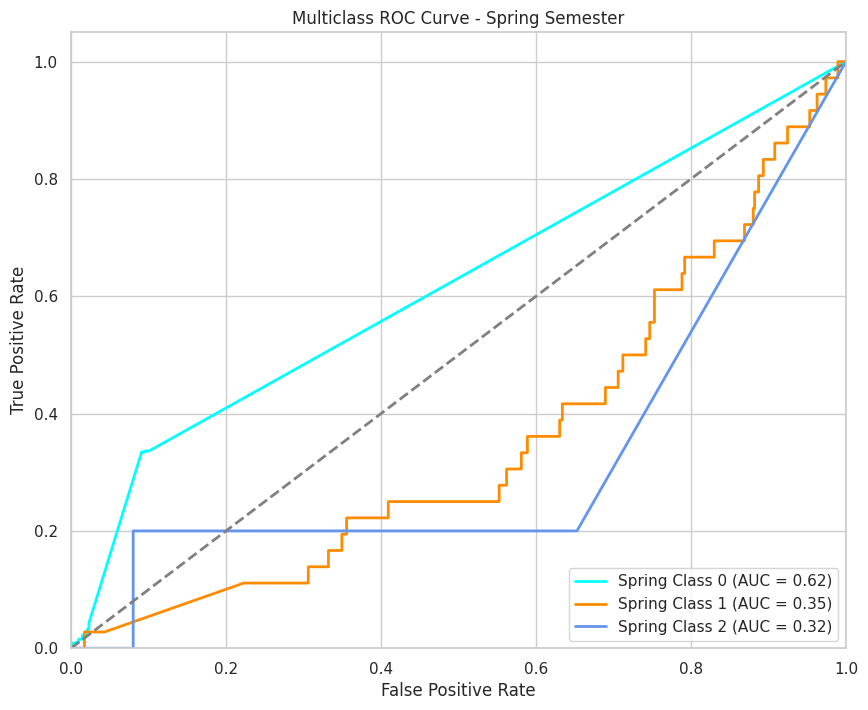

In [23]:
# Plot ROC curves for spring semester
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_spring[i], tpr_spring[i], color=color, lw=2, label=f'Spring Class {i} (AUC = {roc_auc_spring[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve - Spring Semester')
plt.legend(loc="lower right")
plt.show()

<ipython-input-24-61c5825bf476>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='LAMAJOR8I', data=df, palette='viridis')


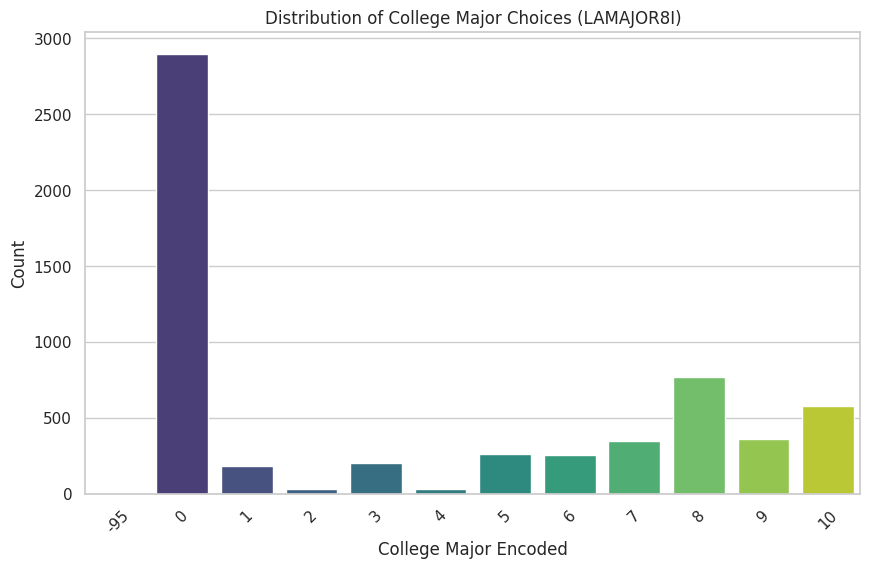

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot of the target variable 'LAMAJOR8I'
plt.figure(figsize=(10, 6))
sns.countplot(x='LAMAJOR8I', data=df, palette='viridis')
plt.title('Distribution of College Major Choices (LAMAJOR8I)')
plt.xlabel('College Major Encoded')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [25]:
# Check the encoded college major values
df['LAMAJOR8I_encoded'].head()


,LAMAJOR8I_encoded
0,1
1,1
2,9
3,1
4,6


<ipython-input-26-27cc616cb2a4>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='LAMAJOR8I', y='GAMTH1C', data=df, palette='Set2')


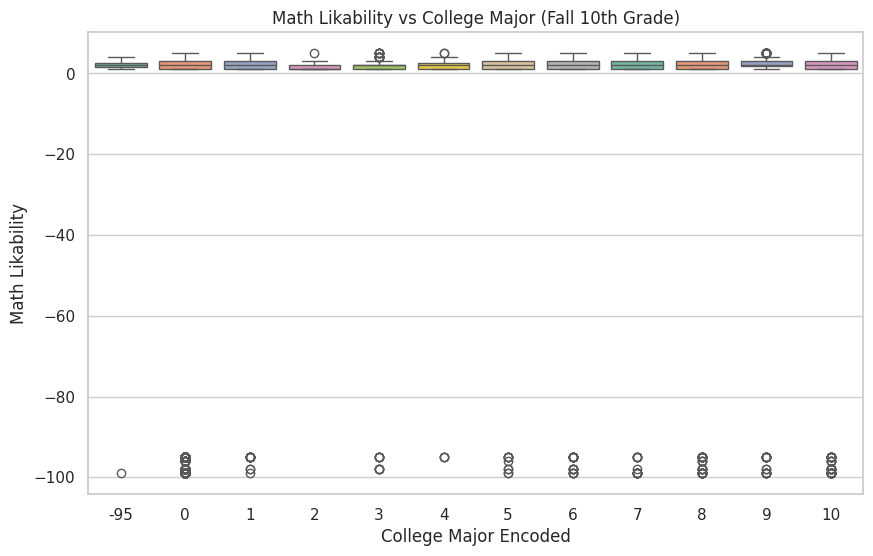

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame and it contains the column 'GAMTH1C'
plt.figure(figsize=(10, 6))

# Boxplot of subject preference vs major
sns.boxplot(x='LAMAJOR8I', y='GAMTH1C', data=df, palette='Set2')

plt.title('Math Likability vs College Major (Fall 10th Grade)')
plt.xlabel('College Major Encoded')
plt.ylabel('Math Likability')
plt.show()




<ipython-input-27-c161d995f416>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='LAMAJOR8I', y='HAMTH1C', data=df, palette='Set2')


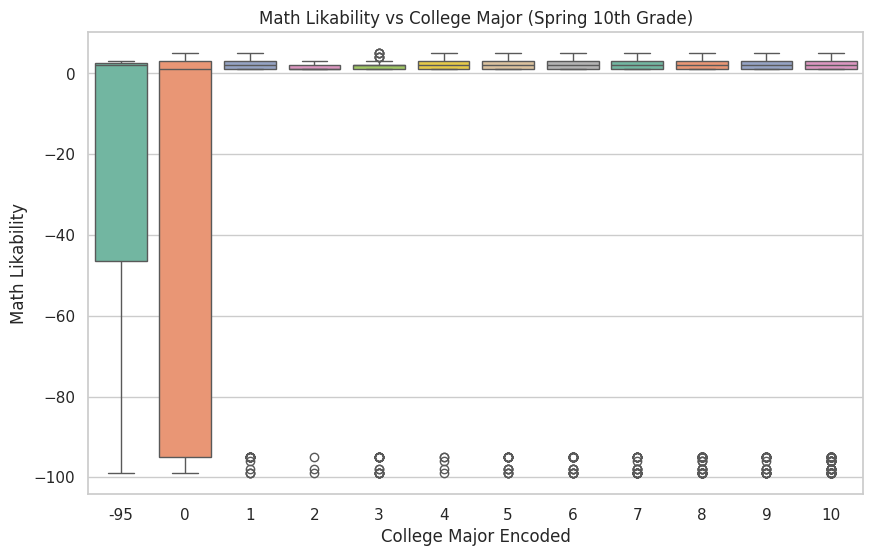

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame and it contains the column 'HAMTH1C'
plt.figure(figsize=(10, 6))

# Boxplot of subject preference vs major
sns.boxplot(x='LAMAJOR8I', y='HAMTH1C', data=df, palette='Set2')

plt.title('Math Likability vs College Major (Spring 10th Grade)')
plt.xlabel('College Major Encoded')
plt.ylabel('Math Likability')
plt.show()


<ipython-input-28-7254d2bb45ff>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='LAMAJOR8I', y='GASCI1C', data=df, palette='Set2')


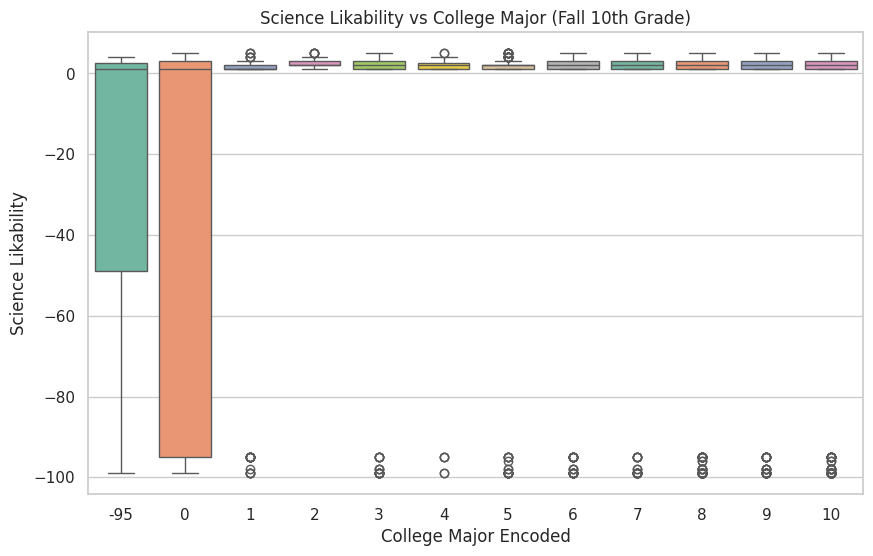

In [28]:
# Assuming df is your DataFrame and it contains the column 'GASCI1C'
plt.figure(figsize=(10, 6))

# Boxplot of science likability vs college major (Fall)
sns.boxplot(x='LAMAJOR8I', y='GASCI1C', data=df, palette='Set2')

plt.title('Science Likability vs College Major (Fall 10th Grade)')
plt.xlabel('College Major Encoded')
plt.ylabel('Science Likability')
plt.show()

<ipython-input-29-f840b66f12ad>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='LAMAJOR8I', y='HASCI1C', data=df, palette='Set2')


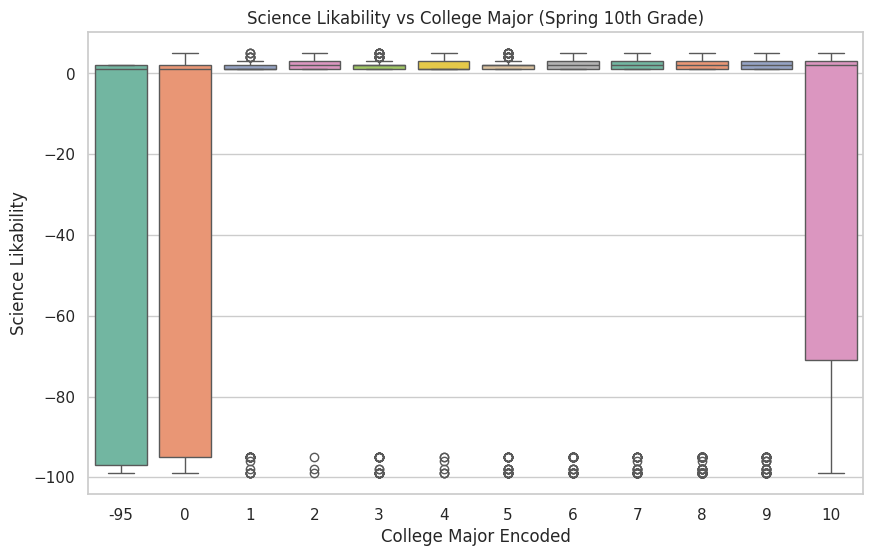

In [29]:
# Assuming df is your DataFrame and it contains the column 'HASCI1C'
plt.figure(figsize=(10, 6))

# Boxplot of science likability vs college major (Spring)
sns.boxplot(x='LAMAJOR8I', y='HASCI1C', data=df, palette='Set2')

plt.title('Science Likability vs College Major (Spring 10th Grade)')
plt.xlabel('College Major Encoded')
plt.ylabel('Science Likability')
plt.show()

<ipython-input-30-eee0b5fdf726>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='LAMAJOR8I', y=col, data=df, palette='Set2')
<ipython-input-30-eee0b5fdf726>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='LAMAJOR8I', y=col, data=df, palette='Set2')
<ipython-input-30-eee0b5fdf726>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='LAMAJOR8I', y=col, data=df, palette='Set2')
<ipython-input-30-eee0b5fdf726>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` vari

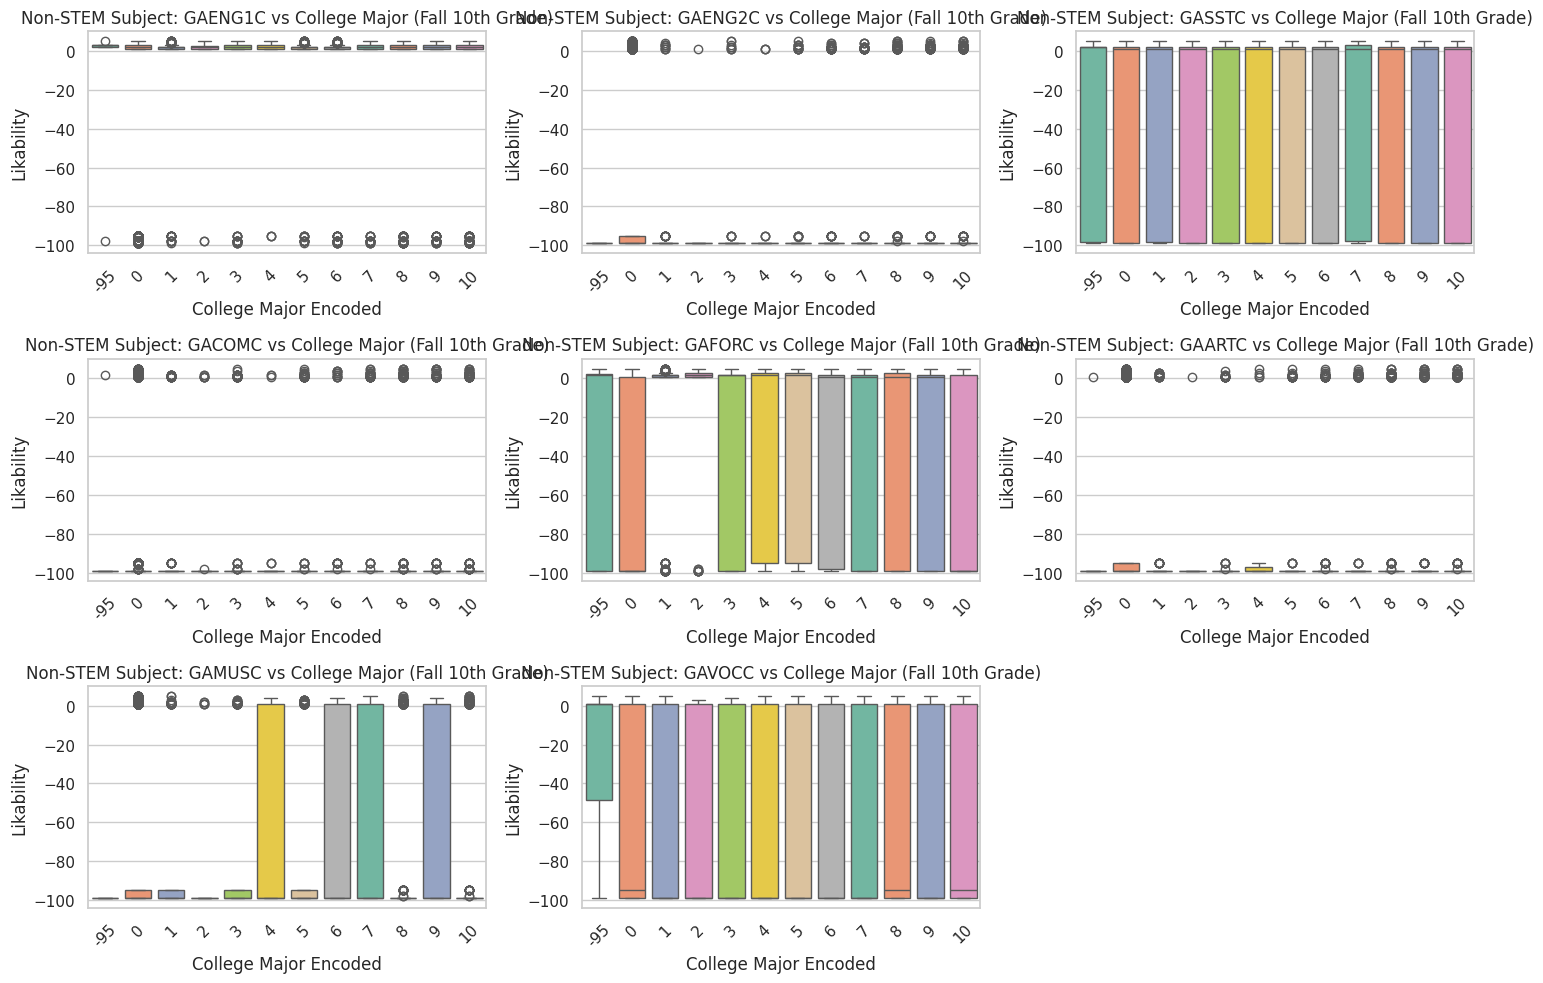

In [30]:
# Create a list of non-STEM columns for fall
non_stem_columns = [
    'GAENG1C', 'GAENG2C', 'GASSTC', 'GACOMC', 'GAFORC',
    'GAARTC', 'GAMUSC', 'GAVOCC'
]

plt.figure(figsize=(15, 10))

for i, col in enumerate(non_stem_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='LAMAJOR8I', y=col, data=df, palette='Set2')
    plt.title(f'Non-STEM Subject: {col} vs College Major (Fall 10th Grade)')
    plt.xlabel('College Major Encoded')
    plt.ylabel('Likability')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

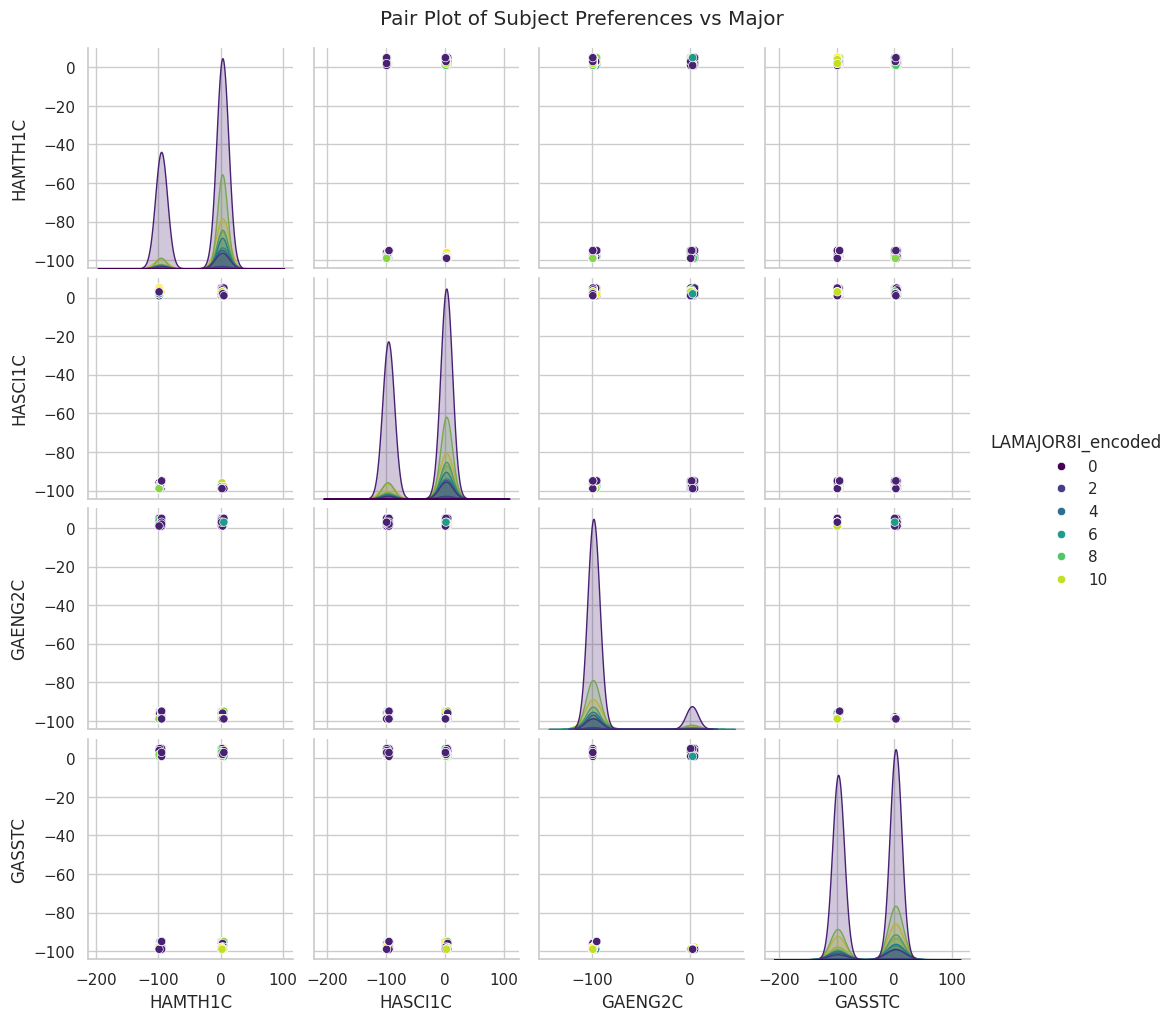

In [31]:
# Pair plot for selected subject preferences
sns.pairplot(df[['HAMTH1C', 'HASCI1C', 'GAENG2C', 'GASSTC', 'LAMAJOR8I_encoded']], hue='LAMAJOR8I_encoded', palette='viridis')
plt.suptitle('Pair Plot of Subject Preferences vs Major', y=1.02)
plt.show()


<ipython-input-32-de8c28eb8a2d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_difficulty.values, y=avg_difficulty.index, palette='coolwarm')


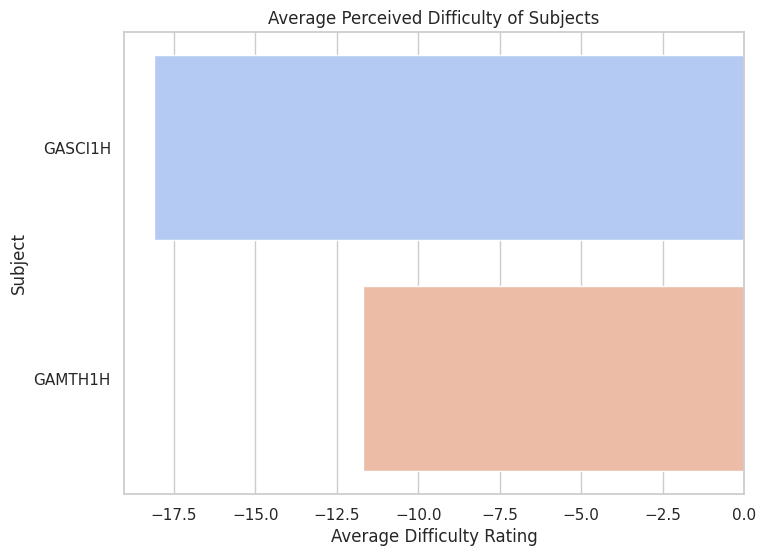

In [32]:
# Bar plot of subject difficulty perceptions
difficulty_cols = ['GAMTH1H', 'GASCI1H']
avg_difficulty = df[difficulty_cols].mean().sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(x=avg_difficulty.values, y=avg_difficulty.index, palette='coolwarm')
plt.title('Average Perceived Difficulty of Subjects')
plt.xlabel('Average Difficulty Rating')
plt.ylabel('Subject')
plt.show()
